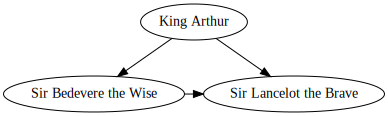

In [115]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

dot

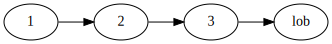

In [116]:
from graphviz import Source

src = Source('digraph "the holy hand grenade" { rankdir=LR; 1 -> 2 -> 3 -> lob }')
src

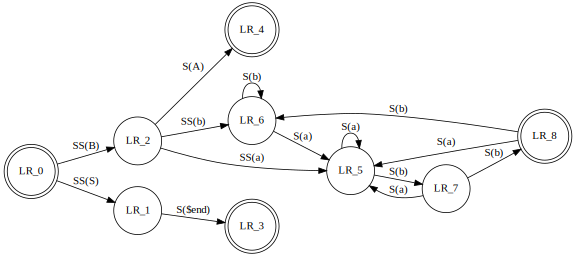

In [117]:
# http://www.graphviz.org/content/fsm

from graphviz import Digraph

f = Digraph('finite_state_machine', filename='fsm.gv')
f.attr(rankdir='LR', size='8,5')

f.attr('node', shape='doublecircle')
f.node('LR_0')
f.node('LR_3')
f.node('LR_4')
f.node('LR_8')

f.attr('node', shape='circle')
f.edge('LR_0', 'LR_2', label='SS(B)')
f.edge('LR_0', 'LR_1', label='SS(S)')
f.edge('LR_1', 'LR_3', label='S($end)')
f.edge('LR_2', 'LR_6', label='SS(b)')
f.edge('LR_2', 'LR_5', label='SS(a)')
f.edge('LR_2', 'LR_4', label='S(A)')
f.edge('LR_5', 'LR_7', label='S(b)')
f.edge('LR_5', 'LR_5', label='S(a)')
f.edge('LR_6', 'LR_6', label='S(b)')
f.edge('LR_6', 'LR_5', label='S(a)')
f.edge('LR_7', 'LR_8', label='S(b)')
f.edge('LR_7', 'LR_5', label='S(a)')
f.edge('LR_8', 'LR_6', label='S(b)')
f.edge('LR_8', 'LR_5', label='S(a)')

f

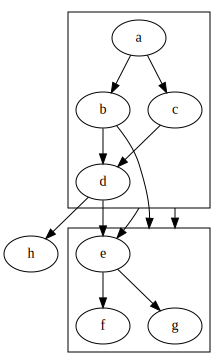

In [118]:
# http://www.graphviz.org/pdf/dotguide.pdf Figure 20

from graphviz import Digraph

g = Digraph('G', filename='cluster_edge.gv')
g.attr(compound='true')

with g.subgraph(name='cluster0') as c:
    c.edges(['ab', 'ac', 'bd', 'cd'])

with g.subgraph(name='cluster1') as c:
    c.edges(['eg', 'ef'])

g.edge('b', 'f', lhead='cluster1')
g.edge('d', 'e')
g.edge('c', 'g', ltail='cluster0', lhead='cluster1')
g.edge('c', 'e', ltail='cluster0')
g.edge('d', 'h')

g

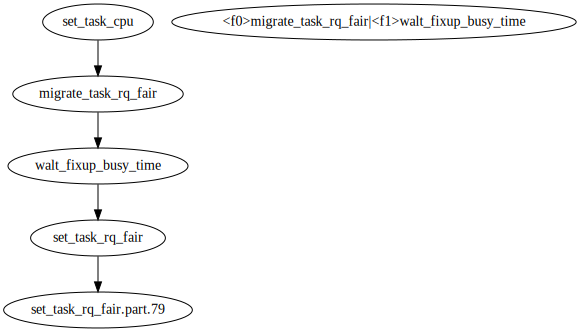

In [119]:
from graphviz import Digraph

g = Digraph('G', filename='cluster_edge.gv')
g.attr(compound='true')



g.edge('set_task_cpu', 'migrate_task_rq_fair')

g.node('a1',"<f0>migrate_task_rq_fair|<f1>walt_fixup_busy_time")

g.edge('migrate_task_rq_fair', 'walt_fixup_busy_time')
g.edge('walt_fixup_busy_time', 'set_task_rq_fair')


g.edge('set_task_rq_fair', 'set_task_rq_fair.part.79')

g

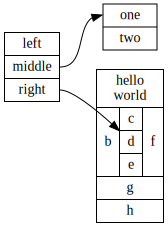

In [120]:
from graphviz import Digraph

s = Digraph('structs', filename='structs_revisited.gv', node_attr={'shape': 'record'})
s.attr(rankdir='LR')
s.node('struct1', '<f0> left|<f1> middle|<f2> right')
s.node('struct2', '<f0> one|<f1> two')
s.node('struct3', r'hello\nworld |{ b |{c|<here> d|e}| f}| g | h')

s.edges([('struct1:f1', 'struct2:f0'), ('struct1:f2', 'struct3:here')])

s

In [1]:
%ls

android/  energy_meter/   trace_analysis/  try_to_wake_up           utils/
devlib/   notebook.ipynb  trappy/          try_to_wake_up_1.cg.dot  wlgen/


In [12]:
archivo = open("try_to_wake_up", 'r')
archivo
from graphviz import Digraph

s = Digraph('structs', filename='structs_revisited.gv', node_attr={'shape': 'record'})
s.attr(rankdir='LR')

In [13]:
import commands
import sys
import string
import random
import os
import hashlib
from optparse import OptionParser
import re

bt_threshold = 3
callgraph_threshold = 3
keep_dot_files = False
is_dtrace = False
output_format = "png"
is_simplify = False
callgraph_level = 0

black_lists_stap = ("kretprobe_trampoline",)
lastest_id=0
def get_random_id():
    global lastest_id
    lastest_id = lastest_id + 1
    return str(lastest_id)

def get_random_id_obsolete():
    return ''.join(random.SystemRandom().choice(string.digits + string.ascii_lowercase) for _ in range(6))

def write_file(basename, suffix, content):
    #outfile = basename + suffix
    #if os.path.exists(outfile):
    outfile = basename + "_" + get_random_id() + suffix
    with open(outfile, "w") as f:
        f.write(content)
    return outfile

def filter_name(funcs):
    newfuncs = []
    for f in funcs:
        if "%" in f or "-" in f[2:]:
            print "Rename func %s  => " % (f,) ,
            if f.startswith('->'):
                f = '->' + f[2:].replace('-', '__').replace('%', '__')
            if f.startswith('<-'):
                f = '<-' + f[2:].replace('-', '__').replace('%', '__')
            print f
        newfuncs.append(f)
    return newfuncs

def which(program):
    import os
    def is_exe(fpath):
        return os.path.isfile(fpath) and os.access(fpath, os.X_OK)

    fpath, fname = os.path.split(program)
    if fpath:
        if is_exe(program):
            return program
    else:
        for path in os.environ["PATH"].split(os.pathsep):
            path = path.strip('"')
            exe_file = os.path.join(path, program)
            if is_exe(exe_file):
                return exe_file

    return None

def deduplicate(files):
    container = {}
    for f in files:
        hash = hashlib.sha256(open(f).read()).hexdigest()
        if hash in container:
            try:
                os.remove(f)
            except OSError:
                pass
            print "Remove duplicate %s" % (f[0:-4], )
        else:
            container[hash] =f
    return container.values()

class Tree:
    class Node:
        def __init__(self, data, name):
            self.data = data
            self.parent = None
            self.children = []
            self.head = self
            self.id = 0
            self.next_id = 0
            self.name = name
            self.is_head = False
            self.first_child = None
            self.is_root = False
 
        def link(self):
            return self.data + "_" + str(self.id)

    def __init__(self, root = None):
        self.root = root;
        self.core_content = ""
        self.id = -1

    def create_node(self, data):
        self.id += 1
        return Tree.Node(data, "a" + str(self.id))

    def clean(self):
        self.root = None
        self.core_content = ""
        self.id = -1

    def same_subtree(self, node1, node2):
        if len(node1.children) != len(node2.children):
            return False
        if len(node1.children) == 0 and node1.data == node2.data:
            return True
        for i in range(0, len(node1.children)):
            if not self.same_subtree(node1.children[i], node2.children[i]):
                return False
        return True

    def _split_node_children(self, children, is_simplify=False):
        uniq_keys = {}
        for child in children:
            if child.data not in uniq_keys:
                uniq_keys[child.data] = child
            else:
                # same, if children are the same
                if is_simplify:
                    if self.same_subtree(uniq_keys[child.data], child):
                        if len(child.children) != 0:
                            child.children = []
                            child.first_child = uniq_keys[child.data].first_child
                            child.is_root = False
                            child.is_head = False
                            #print "Same tree:", child.id,child.name,child.data
                            #print "->", uniq_keys[child.data].id,uniq_keys[child.data].name,uniq_keys[child.data].data

                uniq_keys[child.data].next_id += 1
                child.id = uniq_keys[child.data].next_id

        return children


    def travel_tree(self):
        # skip the first same node
        if len(self.root.children) == 1 and self.root.data == self.root.children[0].data:
            self.root = self.root.children[0]
            self.root.parent = None
            self.root.is_root = True

        self._travel_tree(self.root, 1)

    def _travel_tree(self, node, level):
        uniq_children = self._split_node_children(node.children, is_simplify)
        if node.first_child:
            if node.is_root:
                new_root = "\t %s [label=\"<%s>%s\", color=red];\n" %(node.name, node.data, node.data)
                self.core_content += new_root
                #print new_root
            # Hacker: uniq_children = None && node.first_child !=None, 
            #    means, this node is simplified, and point to the old one.
            if len(uniq_children) != 0:
                new_node = "\t %s [label=\"%s\"];\n" %(node.first_child.name, " | ".join(["<" + i.link() + ">" + i.data for i in uniq_children]))
                self.core_content += new_node
                #print new_node
            left = "\t %s:%s" % (node.head.name, node.link())
            right = "%s:%s" % (node.first_child.name, node.first_child.link())
            style = "[dir=both, arrowtail=dot];\n"
            new_link = "%s -> %s%s" %(left, right, style)
            self.core_content += new_link
            #print new_link

        if level == callgraph_level:
            return
        for child in uniq_children:
            self._travel_tree(child, level + 1)




In [127]:
try:
    with open("pcie_init") as f:
        content = f.readlines()
except:
    sys.exit("No file!")

filter_function = ['_raw_spin_lock_irqsave', '_raw_spin_unlock_irqrestore',  '_raw_spin_lock', '_raw_spin_unlock',
                   '__rcu_read_lock', '__rcu_read_unlock']    
bt_list = []
callgraph_list = []
dotfiles = []
hex_pat = re.compile(r'^0x([0-9a-f]+)$')
def getcpu(linea):
    return linea.split("|")[0].split(")")[0].strip()

def getfunc(linea):
    if "()" in linea:
        return linea.split("|")[1].strip().split("()")[0]
    else:
        return None

is_first = True
root = None
index = None
tree = Tree()
level = 1
for l in content:
    if (len(l.split("|")) >= 1 and len(l.split("|")) < 6):
        func_name = getfunc(l)
        if func_name:
            func_name = func_name.replace('.', '_')
            print "func {} {}".format( func_name, level)
            new_node = tree.create_node(func_name)
            if is_first:
                root = new_node
                index = new_node
                is_first = False
                index.is_root = True
            else:
                new_node.parent = index
                if len(index.children) == 0:
                    new_node.is_first = True
                    index.first_child = new_node
                else:
                    new_node.head = index.first_child
                index.children.append(new_node)
        if not func_name:
            print "no func"
#         new_node = Tree.create_node(func_name)
    if '{' in l:
        index = new_node
        level=level+1
    if '}' in l:
        index = index.parent
        level=level-1
        if level == 1:
            break
    
tree.root = root
tree.travel_tree()
header = """digraph callee {
\tsize="12,16";
\tcenter=true;
\tmargin=0.1;
\tnodesep=2;
\tranksep=0.5;
\trankdir=LR;
\tedge[arrowsize=1.0, arrowhead=vee];
\tnode[shape = record,fontsize=20, width=1, height=1, fixedsize=false];
"""
footer = "\n\t label=\"callgraph of %s\";\n}\n" %(tree.root.data,)
content = "%s%s%s" % (header, tree.core_content, footer)
outfile = write_file(tree.root.data, ".cg.dot", content)
tree.clean()

func acpi_init 1
func acpi_pci_root_add 2
func pci_acpi_scan_root 3
func pci_ecam_create 4
func pci_mcfg_lookup 5
func pci_ecam_create 5
func pci_n1sdp_ccix_init 6
no func
no func
func acpi_pci_root_create 4
func acpi_pci_probe_root_resources 5
func pci_create_root_bus 5
func pci_scan_child_bus 5
func pci_scan_slot 6
func pci_scan_single_device 7
no func
func pci_scan_bridge_extend 9
no func
no func
no func
no func
no func
func pci_find_host_bridge 4
func pci_assign_unassigned_root_bus_resources 4
func __pci_bus_assign_resources 5
func assign_requested_resources_sorted 6
func pci_assign_resource 7
func pci_update_resource 8
no func
no func
no func
func pci_setup_bridge 5
no func
no func
no func
no func


In [128]:
%cat {outfile}

digraph callee {
	size="12,16";
	center=true;
	margin=0.1;
	nodesep=2;
	ranksep=0.5;
	rankdir=LR;
	edge[arrowsize=1.0, arrowhead=vee];
	node[shape = record,fontsize=20, width=1, height=1, fixedsize=false];
	 a0 [label="<acpi_init>acpi_init", color=red];
	 a1 [label="<acpi_pci_root_add_0>acpi_pci_root_add"];
	 a0:acpi_init_0 -> a1:acpi_pci_root_add_0[dir=both, arrowtail=dot];
	 a2 [label="<pci_acpi_scan_root_0>pci_acpi_scan_root | <pci_find_host_bridge_0>pci_find_host_bridge | <pci_assign_unassigned_root_bus_resources_0>pci_assign_unassigned_root_bus_resources"];
	 a1:acpi_pci_root_add_0 -> a2:pci_acpi_scan_root_0[dir=both, arrowtail=dot];
	 a3 [label="<pci_ecam_create_0>pci_ecam_create | <acpi_pci_root_create_0>acpi_pci_root_create"];
	 a2:pci_acpi_scan_root_0 -> a3:pci_ecam_create_0[dir=both, arrowtail=dot];
	 a4 [label="<pci_mcfg_lookup_0>pci_mcfg_lookup | <pci_ecam_create_0>pci_ecam_create"];
	 a3:pci_ecam_create_0 -> a4:pci_mcfg_lookup_0[dir=both, arrowtail=dot];
	 a6 [label="<pci_

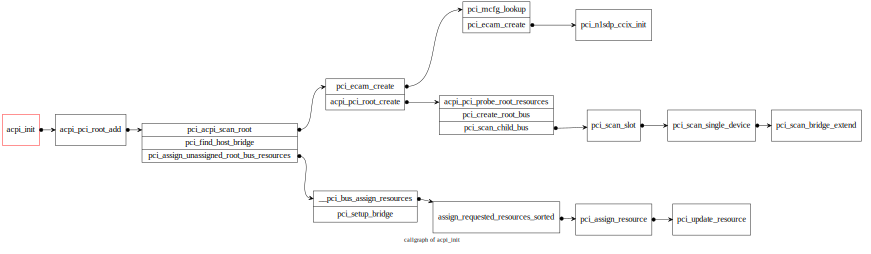

In [137]:
from graphviz import Source

ss = Source.from_file(outfile, format='png')
ss

In [141]:
ss.render('pcie_init.png', view=True)  

'pcie_init.png.png'